Шорохов Илья Александрович 
tg - @iashorokhov

# Мэтчинг наиболее похожих товаров из набора данных

## План работы

- Загрузить и ознакомиться с данными
- Провести EDA для оценки признаков
- Разработать алгоритм подбора k ближайших соседей
- Протестировать алгоритм на тестовой выборке
- Оценить качество работы алгоритма с помощью метрики accuracy@5 
- Доработать алгоритм, если потребуется
- Протестировать подход на валидационной выборке 
- Написать общий вывод

## Цель работы

- Разработать алгоритм подбора наиболее подходящих товаров для выборки validation.csv из датасета base.csv и протестировать алгоритм с помощью метрики accuracy@5

## Описание данных 

- base.csv анонимизированный набор товаров. Каждый товар представлен как уникальный id и вектор размерностью 72
- train.csv обучающий датасет. Каждая строчка - товар, для которого известен уникальный, вектор признаков и id товаров из base.csv, который максимально поход на него (по мнению экспертов). Т.е. - это файл с размеченными данными
- validation.csv - датасет с товарами, для который нужно было найти похожие (протестировать алгоритм)
- validation_answer - датасет с ответами к validation.csv, необходимый для подсчета метрики accuracy@5

# Установка библиотек

In [1]:
pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 45.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import faiss
from tqdm.notebook import tqdm

In [3]:
pd.set_option('display.max_columns', 80)

In [4]:
k = 5

## Загрузка данных

Уменьшаяем объем памяти заменой float64 на float32

In [5]:
dict_base ={}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

In [6]:
len(dict_base)

72

In [7]:
df_base = pd.read_table('/kaggle/input/data-complete/base.csv', index_col=0, sep=',', dtype=dict_base)
df_base.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.81218,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.83284,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.97963,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206


In [8]:
df_train = pd.read_csv('/kaggle/input/data-complete/train.csv', index_col=0)
df_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.82184,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.25095,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.51382,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.78345,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.63687,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.63211,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.12843,-50.83762,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.32178,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.86585,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.67767,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.93147,-1074.464888,-22.547178,1447819-base


In [9]:
print('Размер датасета base:', df_base.shape)

Размер датасета base: (2918139, 72)


In [10]:
print('Размер датасета train:', df_train.shape)

Размер датасета train: (100000, 73)


In [11]:
df_valid = pd.read_csv('/kaggle/input/data-complete/validation.csv', index_col=0)

In [12]:
df_valid.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.57952,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.12400,-24.996636,76.15390,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.05548,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.95395,-18.408230,90.51705,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.60767,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.27615,-45.909942,103.49136,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604


In [13]:
print('Размер датасета valid:', df_valid.shape)

Размер датасета valid: (100000, 72)


## EDA

Построим графики для всех признаков из датасета train, чтобы понять, можно ли избавиться от каких-то из них

In [14]:
# Возьмем небольшой семпл, чтобы не строить графики для всех 2 миллионов наблюдений
df_sample = df_train[:10000]

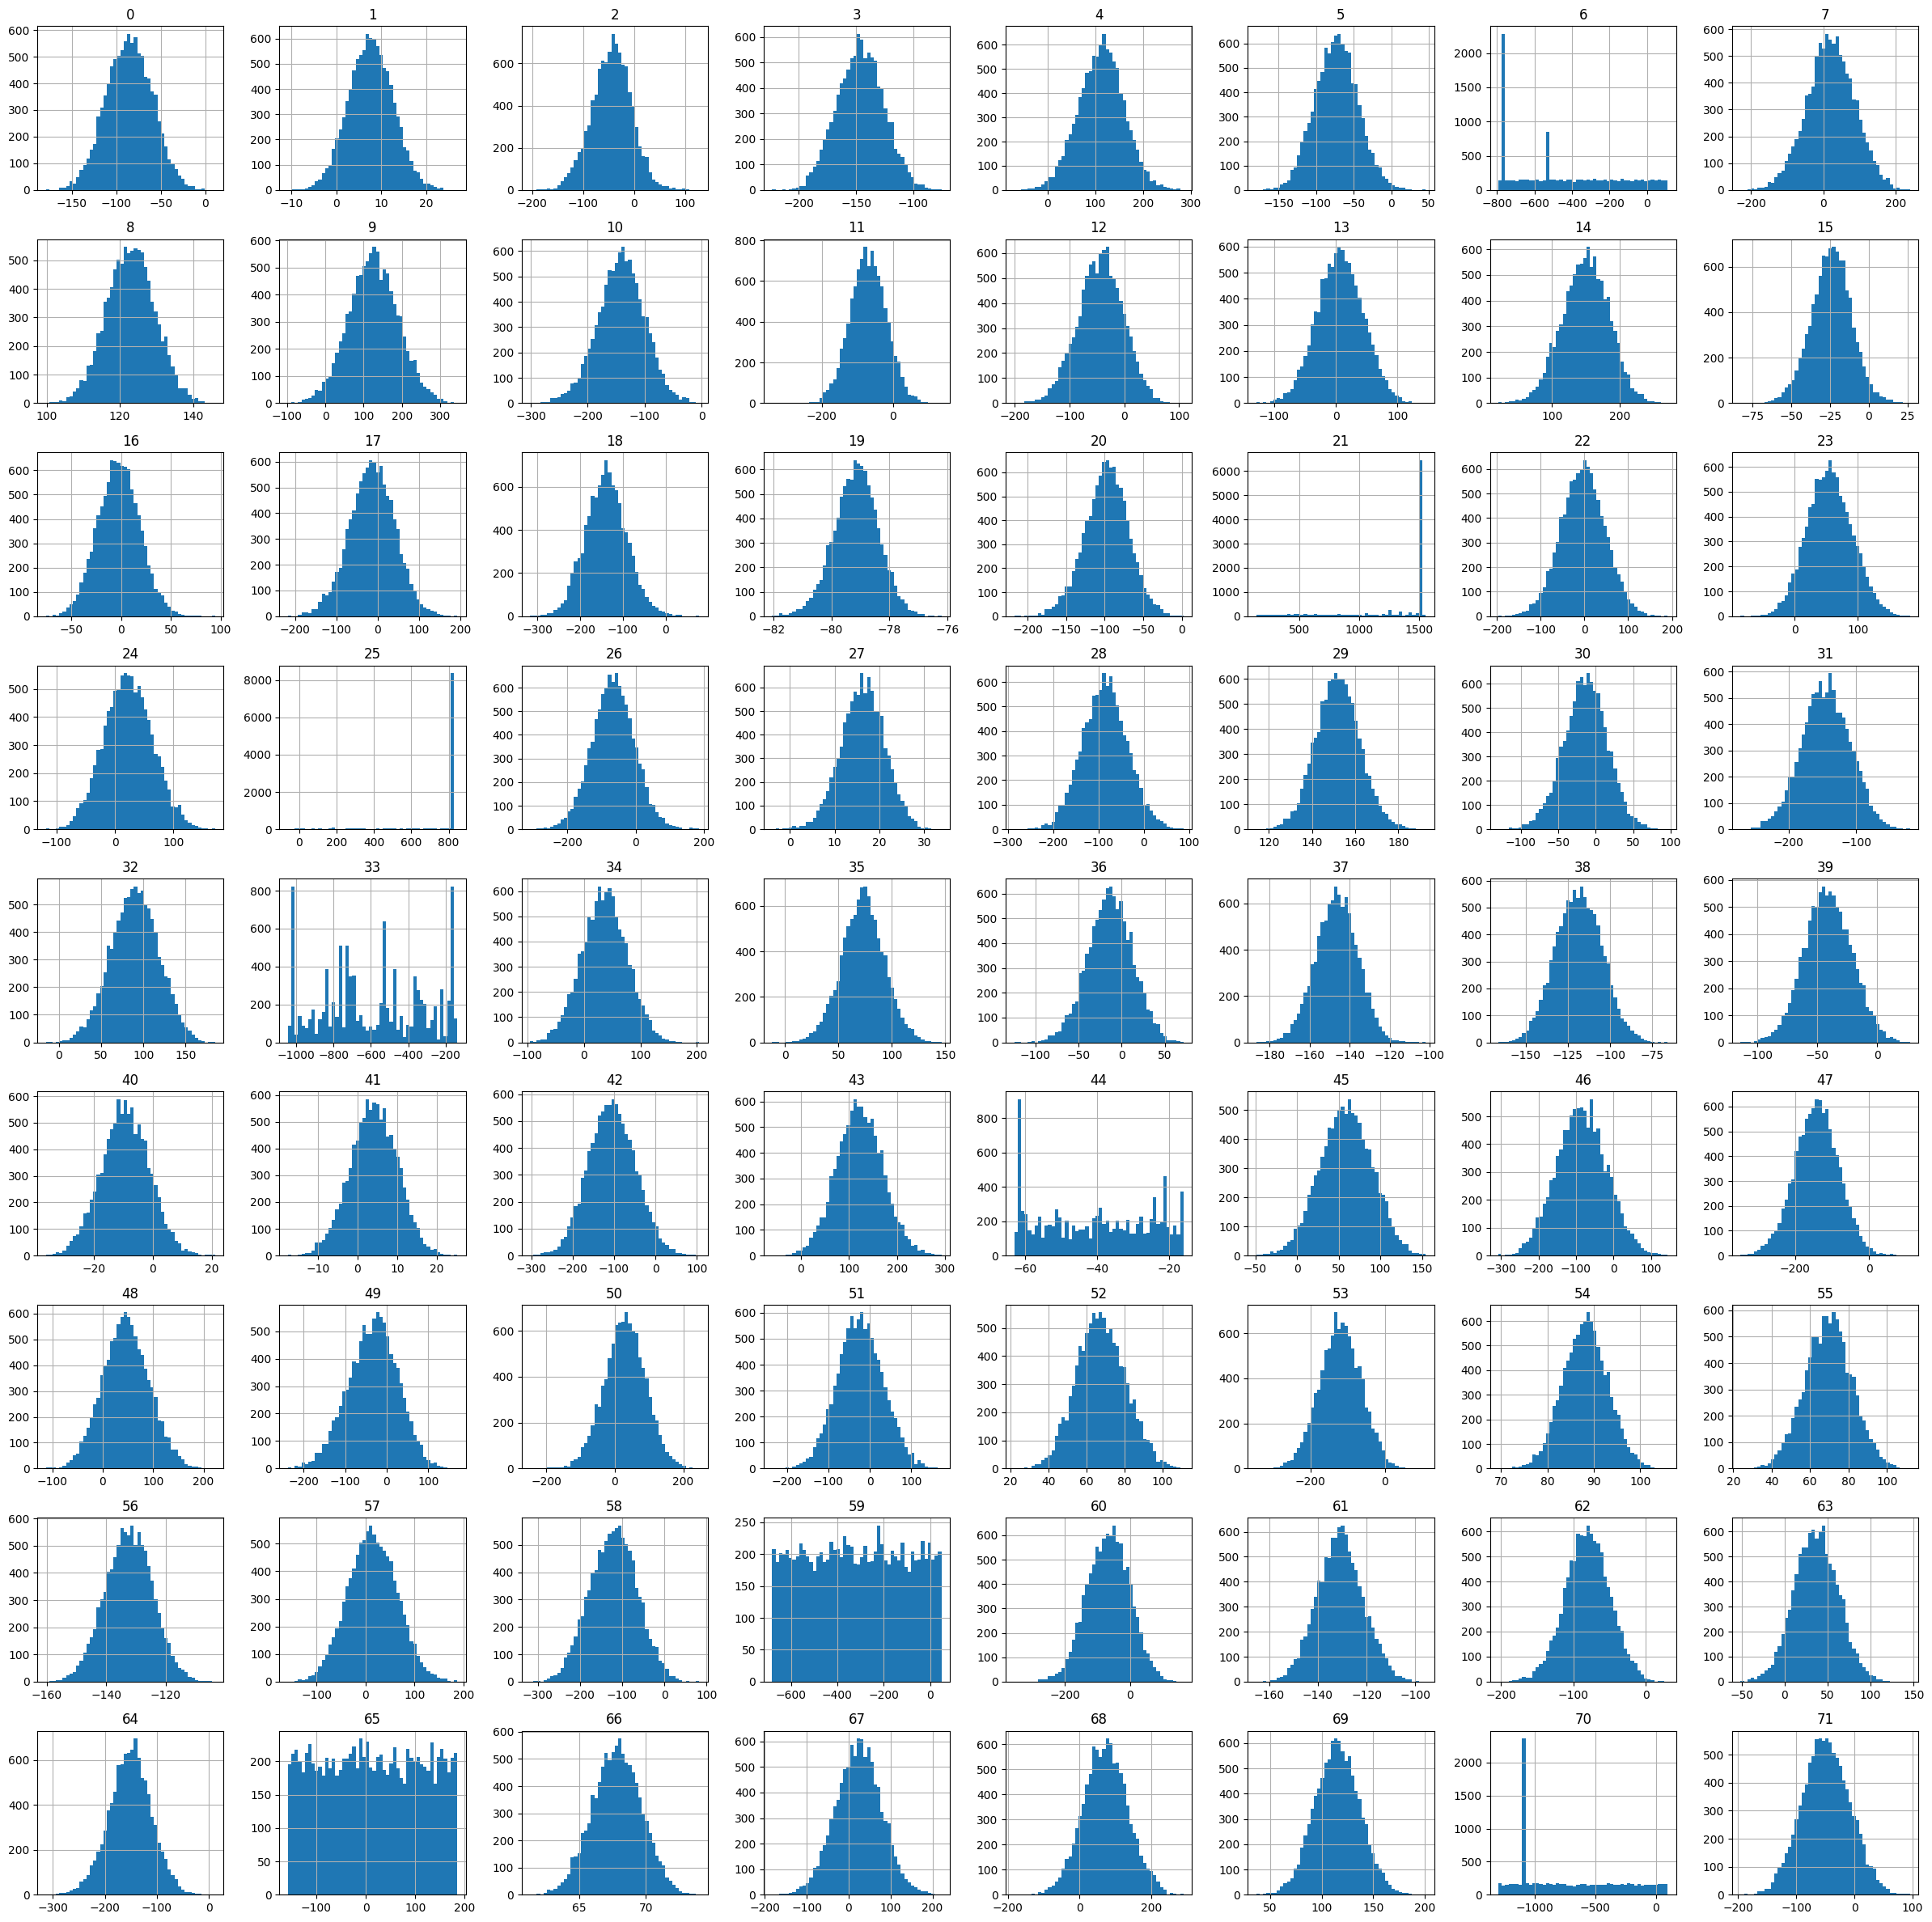

In [15]:
# Строим гистограммы для всех признаков
df_sample.hist(figsize=[30,30], bins=50); 

Из гистограмм видно, что большинство признаков имеют нормальное распределение, а некоторые из них нет. Попробуем оставить только признаки с нормальным распределением

In [16]:
# Выделяем список признаков, которые будем удалять
columns_to_remove = ['6', '21', '25', '33', '44', '59', '65', '70']

In [17]:
# Удаляем лишние столбцы из всех датасетов
df_base = df_base.drop(columns=columns_to_remove)
print('Размер датасета base после чистки:', df_base.shape)

Размер датасета base после чистки: (2918139, 64)


In [18]:
df_train = df_train.drop(columns=columns_to_remove)
print('Размер датасета train после чистки:', df_train.shape)

Размер датасета train после чистки: (100000, 65)


In [19]:
df_valid = df_valid.drop(columns=columns_to_remove)
print('Размер датасета valid после чистки:', df_valid.shape)

Размер датасета valid после чистки: (100000, 64)


### Промежуточный итог

- Данные загружены
- Уменьшен объем памяти посредством замены float64 на float32
- Проведен минимальный EDA
- По результатам анализа гистограмм удалены признаки, не имеющие нормального распределения

## Применение библиотеки FAISS
### Создание индексов

In [20]:
# Определяем количество столбоцв
dims = df_base.shape[1]

# Оозначаем переменную n_cells, которую будем использовать далее
n_cells = 300

# Создаем quantizer, который является индексом, используемым для поиска ближайших соседей в векторном пространстве с использованием L2-нормы
quantizer = faiss.IndexFlatL2(dims)

# И наконец создаем сам индекс для поиска ближайших соседей с использованием инвертированного индекса и L2-нормы
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [21]:
quantizer.ntotal

0

In [22]:
# Обучаем модель на первых 20 000 элементов
idx_l2.train(np.ascontiguousarray(df_base.values[:20000, :]).astype('float32'))

# Добавляем данные в модель для дальнейшего использования 
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [23]:
# Проверяем сколько точек будет рассматривать модель
idx_l2.nprobe

1

In [24]:
# Создаем словарь с парами ключ-значение, где ключем будет индекс строки, а значением - значения из df_base
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [25]:
# Преобразовываем ключи в список
list__ = list(base_index.keys())

# Выводим сред первых 20 элементов
list__[:20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [26]:
# Получаем список названия столбцов 
df_base.columns
df_train.columns
df_valid.columns

Index(['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27',
       '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', '57', '58', '60', '61', '62', '63', '64', '66', '67',
       '68', '69', '71'],
      dtype='object')

### Тестируем модель

In [27]:
# Выделяем признаки и целевой признак
targets = df_train['Target']
df_train.drop('Target', axis=1, inplace=True)

In [28]:
# Выполняем поиск по ближайшим соседям
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), k)

# Задаем переменную acc для подсчета количества правильно предсказанных примеров 
acc = 0 
for target, el in zip(targets.values.tolist(), idx.tolist()): #выполняется цикл по парам значений из списка целевых значений и списка индексов соседей 
    acc += int(target in [base_index[r] for r in el]) # если условие выполняется, acc увеличивается на 1

# Выводим значение метрики accuracy@5 для полученных предсказаний
# Результатом является отношение суммы правильно предсказанных к общему количеству примеров в списке "idx", умноженное на 100
print('Метрика accuracy@5:', 100 * acc / len(idx))

Метрика accuracy@5: 59.609


Попробуем нормализировать данные с помощью StandardScaler


In [29]:
# Создаем объект scaler
scaler = StandardScaler()

In [30]:
# Применяем scaler к наборам данных
df_base2 = scaler.fit_transform(df_base)

In [31]:
df_train2 = scaler.transform(df_train)

In [32]:
# Повторно создаем индексы и обучаем модель

dims = df_base2.shape[1]

n_cells = 10

quantizer2 = faiss.IndexFlatL2(dims)

idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [33]:
idx_l2.train(np.ascontiguousarray(df_base2[:20000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))

In [34]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train2).astype('float32'), k)

acc = 0 
for target, el in zip(targets.values.tolist(), idx.tolist()): 
    acc += int(target in [base_index[r] for r in el]) 

print('Метрика accuracy@5:', 100 * acc / len(idx))

Метрика accuracy@5: 63.629


Как видно метрика улучшилась после нормализации данных. Осталось проверить модель на валидационной выборке

In [35]:
df_valid2 = scaler.transform(df_valid)

In [36]:
answer = pd.read_csv('/kaggle/input/data-complete/validation_answer.csv', index_col=0)

In [37]:
answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [38]:
targets_valid = answer['Expected']

In [40]:
vecs_valid, idx_valid = idx_l2.search(np.ascontiguousarray(df_valid2).astype('float32'), k)

In [41]:
acc_valid = 0
for target, el in zip(targets_valid.values.tolist(), idx_valid.tolist()):
    acc_valid += int(target in [base_index[r] for r in el])

print('Метрика accuracy@5 (на выборке validation):', 100 * acc_valid / len(idx_valid))

Метрика accuracy@5 (на выборке validation): 63.449


## Общий вывод

- Данные были загружены в переменные df_base, df_train, df_valid и answer
- В качестве небольшого EDA были построены графики для всех признаков
- На графиках были выявлены и удалены признаки не имеющие нормального распределения
- Для построения алгоритма использовалась библиотека Faiss
- Количество соседей выбрано равным 5
- Для обучения модели использовалось 20 000 наблюдений из обучающей выборки
- В качестве метрики для оценки модели использовалась accuracy@5
- По результатам предварительного тестирования, значение метрики составило 59.6 
- Для улучшения метрики был применен StandardScaler 
- После нормализации данных метрика accuracy@5 составила уже 63.6
- В конечном итоге модель была протестирована на валидационной выборке
- В качестве целевых значений были взяты данные из датасета validation_answers.csv
- При тестировании получено значение метрики accuracy@5 равное 63.4